# UNIÓN + EDA TABLA UNIFICADA

Este notebook tiene como objetivo integrar y analizar de forma conjunta tres fuentes principales de datos sobre pares enfermedad–fármaco:
- `dr_gnns`: métricas generadas a partir de modelos de Graph Neural Networks (GNNs),
- `dr_information_paths`:  identifica la presencia de rutas específicas en el grafo biomédico entre enfermedad y fármaco,
- `dr_network_proximity`:  cuantifica la proximidad entre nodos en la red de interacciones biomédicas.

Tras la unificación, se genera una única tabla estructurada que servirá como base para el metamodelo.
El análisis exploratorio posterior incluye estadísticas generales, análisis de duplicados y valores nulos, comparación de distribuciones, detección de outliers mediante boxplots, visualización de histogramas y estudio de correlaciones entre variables.


# 1 LIBRERÍAS

In [1]:
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2 UNIÓN DE TABLAS

In [2]:
ruta_gnn = "../data/interim/Gnn2_DiseaseDrug_parquet"
ruta_paths = "../data/interim/dr_information_paths_pivot_parquet"
ruta_network = "../data/raw/dr_network_proximity_parquet"

In [3]:
Gnn_DiseaseDrug = dd.read_parquet(ruta_gnn)
Information_Paths = dd.read_parquet(ruta_paths)
Network_Proximity = dd.read_parquet(ruta_network)

Nos aseguramos de que los tipos de datos coincidan en todas las tablas.

In [4]:
Gnn_DiseaseDrug["disease_id"] = Gnn_DiseaseDrug["disease_id"].astype(str)
Gnn_DiseaseDrug["drug_id"] = Gnn_DiseaseDrug["drug_id"].astype(str)
Information_Paths["disease_id"] = Information_Paths["disease_id"].astype(str)
Information_Paths["drug_id"] = Information_Paths["drug_id"].astype(str)
Network_Proximity["disease_id"] = Network_Proximity["disease_id"].astype(str)
Network_Proximity["drug_id"] = Network_Proximity["drug_id"].astype(str)

Hacemos un inner join para quedarnos con las filas presentes en ambas tablas para aquellos pares enfermedad-fármaco. Se hizo de esta manera para reducir el tamaño del DataFrame final.

In [5]:
NetProx_InfoPath = Information_Paths.merge(
    Network_Proximity,
    on=["disease_id", "drug_id"],
    how="inner"
)

Guardamos los datos del primer inner join, ya que en ocasiones pueden surgir problemas al cargarlos posteriormente.

In [11]:
NetProx_InfoPath.to_parquet("../data/extra/NetProx_InfoPath_parquet", write_index=False)

In [6]:
NetProx_InfoPath = dd.read_parquet("../data/extra/NetProx_InfoPath_parquet")

In [7]:
NetProx_InfoPath.head()

disease_id     drug_id  path_1  path_2  path_4  path_5  closest_distance  \
0   C0001973  CHEMBL1000       0       0       1       0           2.00000   
1   C0001973  CHEMBL1005       0       0       1       1           1.33333   
2   C0001973  CHEMBL1006       0       0       1       0           2.00000   
3   C0001973  CHEMBL1008       0       0       1       0           1.80000   
4   C0001973  CHEMBL1009       0       0       1       1           1.20000   

   dc_mean    dc_std  proximity  
0  1.82700  0.391243   0.442181  
1  1.65933  0.255063  -1.278110  
2  1.90600  0.370357   0.253809  
3  1.88880  0.131351  -0.676051  
4  1.97955  0.209331  -3.724010

In [8]:
NetProx_InfoPath["disease_id"] = NetProx_InfoPath["disease_id"].astype(str)
NetProx_InfoPath["drug_id"] = NetProx_InfoPath["drug_id"].astype(str)

In [9]:
Gnn_DiseaseDrugInfoPath_NetProx = NetProx_InfoPath.merge(
    Gnn_DiseaseDrug,
    on=["disease_id", "drug_id"],
    how="inner"
)

Guardamos esta última tabla, que será la que utilizaremos a partir de ahora.

In [22]:
Gnn_DiseaseDrugInfoPath_NetProx.to_parquet("../data/extra/particiones_Gnn_DiseaseDrugInfoPath_NetProx_parquet", write_index=False)

In [2]:
Gnn_DiseaseDrugInfoPath_NetProx = dd.read_parquet("../data/extra/particiones_Gnn_DiseaseDrugInfoPath_NetProx_parquet")

# 3 EDA

Realizamos análisis exploratorio de la tabla unificada

## 3.1 Información General

In [11]:
print("Columnas disponibles en el DataFrame combinado:")
print(Gnn_DiseaseDrugInfoPath_NetProx.columns)

Columnas disponibles en el DataFrame combinado:
Index(['disease_id', 'drug_id', 'path_1', 'path_2', 'path_4', 'path_5',
       'closest_distance', 'dc_mean', 'dc_std', 'proximity', 'behor', 'behorC',
       'dmsr', 'dmsrC', 'class'],
      dtype='object')


In [12]:
print(type(Gnn_DiseaseDrugInfoPath_NetProx))

<class 'dask.dataframe.dask_expr._collection.DataFrame'>


In [13]:
Gnn_DiseaseDrugInfoPath_NetProx.head()

disease_id     drug_id  path_1  path_2  path_4  path_5  closest_distance  \
0   C0001973  CHEMBL1000       0       0       1       0           2.00000   
1   C0001973  CHEMBL1005       0       0       1       1           1.33333   
2   C0001973  CHEMBL1006       0       0       1       0           2.00000   
3   C0001973  CHEMBL1008       0       0       1       0           1.80000   
4   C0001973  CHEMBL1009       0       0       1       1           1.20000   

   dc_mean    dc_std  proximity     behor  behorC  dmsr     dmsrC  class  
0  1.82700  0.391243   0.442181  0.999997     1.0   1.0  1.000000      0  
1  1.65933  0.255063  -1.278110  1.000000     1.0   1.0  1.000000      0  
2  1.90600  0.370357   0.253809  1.000000     1.0   1.0  1.000000      0  
3  1.88880  0.131351  -0.676051  0.999961     1.0   1.0  0.999993      0  
4  1.97955  0.209331  -3.724010  1.000000     1.0   1.0  1.000000      0

In [14]:
Gnn_DiseaseDrugInfoPath_NetProx["disease_id"] = Gnn_DiseaseDrugInfoPath_NetProx["disease_id"].astype(str)
Gnn_DiseaseDrugInfoPath_NetProx["drug_id"] = Gnn_DiseaseDrugInfoPath_NetProx["drug_id"].astype(str)

In [15]:
print("\nTipos:")
print(Gnn_DiseaseDrugInfoPath_NetProx.dtypes)


Tipos:
disease_id           object
drug_id              object
path_1                int64
path_2                int64
path_4                int64
path_5                int64
closest_distance    float64
dc_mean             float64
dc_std              float64
proximity           float64
behor               float64
behorC              float64
dmsr                float64
dmsrC               float64
class                 int32
dtype: object


## 3.2 Número de filas y columnas

In [16]:
num_filas = Gnn_DiseaseDrugInfoPath_NetProx.shape[0].compute()  # Número de filas
num_cols = len(Gnn_DiseaseDrugInfoPath_NetProx.columns)  # Número de columnas
print(f"\nFilas: {num_filas}  Columnas: {num_cols}")


Filas: 123638  Columnas: 15


Observamos que al hacer inner join el número de filas ha reducido considerablemente.

Al no ser muchas filas, se pueden almacenar en 1 única partición para trabajar mejor con los datos, hacer .compute() y usar pandas en vez de Dask.

In [28]:
Gnn_DiseaseDrugInfoPath_NetProx1 = Gnn_DiseaseDrugInfoPath_NetProx.repartition(npartitions=1)

In [29]:
Gnn_DiseaseDrugInfoPath_NetProx1.to_parquet("../data/unified/table_completed_parquet", write_index=False)

In [7]:
Gnn_DiseaseDrugInfoPath_NetProx1 = dd.read_parquet("../data/unified/table_completed_parquet")

In [18]:
Gnn_DiseaseDrugInfoPath_NetProx1.map_partitions(len).compute()

0    123638
dtype: int64

In [8]:
df_unificado = Gnn_DiseaseDrugInfoPath_NetProx1.compute()

Como hemos hecho .compute(), estamos trabajando con pandas, por lo que podemos hacer .describe() para obtener más información de los datos

In [20]:
df_class0 = df_unificado[df_unificado["class"] == 0]
df_class1 = df_unificado[df_unificado["class"] == 1]

In [21]:
df_class0.describe()

path_1    path_2         path_4         path_5  \
count  119167.000000  119167.0  119167.000000  119167.000000   
mean        0.005496       0.0       0.998221       0.217258   
std         0.073935       0.0       0.042141       0.412381   
min         0.000000       0.0       0.000000       0.000000   
25%         0.000000       0.0       1.000000       0.000000   
50%         0.000000       0.0       1.000000       0.000000   
75%         0.000000       0.0       1.000000       0.000000   
max         1.000000       0.0       1.000000       1.000000   

       closest_distance        dc_mean         dc_std      proximity  \
count     117116.000000  117116.000000  117116.000000  115736.000000   
mean           1.796714       1.806556       0.304214       0.011885   
std            0.558880       0.350780       0.126284       1.315443   
min            0.000000       0.000000       0.000000      -9.569350   
25%            1.500000       1.624485       0.208693      -0.690549   
50%            2.000000       1.841000       0.294947       0.156049   
75%            2.000000       2.014193       0.391343       0.781768   
max            4.000000       2.872100       0.797897       5.179220   

               behor         behorC           dmsr          dmsrC     class  
count  119167.000000  119167.000000  119167.000000  119167.000000  119167.0  
mean        0.926942       0.982041       0.903165       0.952510       0.0  
std         0.196990       0.097073       0.235357       0.166545       0.0  
min         0.036303       0.031280       0.016483       0.018077       0.0  
25%         0.994105       1.000000       0.990665       0.999728       0.0  
50%         0.999999       1.000000       0.999999       1.000000       0.0  
75%         1.000000       1.000000       1.000000       1.000000       0.0  
max         1.000000       1.000000       1.000000       1.000000       0.0

In [22]:
df_class1.describe()

path_1       path_2       path_4       path_5  closest_distance  \
count  4471.000000  4471.000000  4471.000000  4471.000000       4394.000000   
mean      0.012525     0.960412     0.997316     0.530977          1.530957   
std       0.111225     0.195012     0.051743     0.499095          0.620153   
min       0.000000     0.000000     0.000000     0.000000          0.000000   
25%       0.000000     1.000000     1.000000     0.000000          1.000000   
50%       0.000000     1.000000     1.000000     1.000000          1.642860   
75%       0.000000     1.000000     1.000000     1.000000          2.000000   
max       1.000000     1.000000     1.000000     1.000000          3.000000   

           dc_mean       dc_std    proximity        behor       behorC  \
count  4394.000000  4394.000000  4345.000000  4471.000000  4471.000000   
mean      1.716102     0.277573    -0.788513     0.998183     0.999685   
std       0.398616     0.126930     1.686834     0.025271     0.011889   
min       0.000000     0.000000    -8.657840     0.158338     0.275314   
25%       1.509355     0.176472    -1.616130     1.000000     1.000000   
50%       1.761995     0.257077    -0.435267     1.000000     1.000000   
75%       1.946695     0.359466     0.389846     1.000000     1.000000   
max       2.822110     0.604897     5.101670     1.000000     1.000000   

              dmsr        dmsrC   class  
count  4471.000000  4471.000000  4471.0  
mean      0.998176     0.998319     1.0  
std       0.025021     0.025492     0.0  
min       0.158709     0.201951     1.0  
25%       1.000000     1.000000     1.0  
50%       1.000000     1.000000     1.0  
75%       1.000000     1.000000     1.0  
max       1.000000     1.000000     1.0

## 3.3 Enfermedades y fármacos únicos

In [23]:
num_enfermedades = df_unificado['disease_id'].nunique()
print(f"Número de enfermedades únicas: {num_enfermedades}")

num_farmacos = df_unificado['drug_id'].nunique()
print(f"Número de fármacos únicos: {num_farmacos}")

Número de enfermedades únicas: 116
Número de fármacos únicos: 1088


### Enfermedades y fármacos únicos por class

In [24]:
df_class_1 = df_unificado[df_unificado['class'] == 1]
num_enfermedades_class_1 = df_class_1['disease_id'].nunique()
num_farmacos_class_1 = df_class_1['drug_id'].nunique()

print(f"Número de enfermedades únicas (class = 1 (treatment)): {num_enfermedades_class_1}")
print(f"Número de fármacos únicos (class = 1 (treatment)): {num_farmacos_class_1}")

Número de enfermedades únicas (class = 1 (treatment)): 116
Número de fármacos únicos (class = 1 (treatment)): 614


In [25]:
# Filtrar por clase 0
df_class_0 = df_unificado[df_unificado['class'] == 0]
num_enfermedades_class_0 = df_class_0['disease_id'].nunique()
num_farmacos_class_0 = df_class_0['drug_id'].nunique()

print(f"Número de enfermedades únicas (class = 0 (unknown)): {num_enfermedades_class_0}")
print(f"Número de fármacos únicos (class = 0 (unknown)): {num_farmacos_class_0}")

Número de enfermedades únicas (class = 0 (unknown)): 116
Número de fármacos únicos (class = 0 (unknown)): 1088


Observamos que el número de enfermedades únicas es igual, variando el número de fármacos únicos por clase.

## 3.4 Proporción de class (unknown vs treatment)

In [26]:
num_filas = len(df_unificado)
num_filas_1 = (df_unificado["class"] == 1).sum()
num_filas_0 = (df_unificado["class"] == 0).sum()

porcentaje_class_1 = (num_filas_1 / num_filas) * 100
porcentaje_class_0 = 100 - porcentaje_class_1

In [27]:
print(f"Número de filas total: {num_filas}")
print(f"Número de CLASS = 1 (treatment): {num_filas_1}")
print(f"Número de CLASS = 0 (unknown): {num_filas_0}")

Número de filas total: 123638
Número de CLASS = 1 (treatment): 4471
Número de CLASS = 0 (unknown): 119167


In [28]:
print(f"\nPorcentaje de CLASS = 1 (treatment): {porcentaje_class_1:.4f}%")
print(f"Porcentaje de CLASS = 0 (unknown): {porcentaje_class_0:.4f}%")


Porcentaje de CLASS = 1 (treatment): 3.6162%
Porcentaje de CLASS = 0 (unknown): 96.3838%


Observamos que, al unir las tabla, la proporción de pares enfermedad-fármaco en class 1 ha aumentando respecto a la tabla base dr_gnns, lo que ayudará al metamodelo. Aún así, se observa un claro desequilibrio de clases.

### Gráficas número de tratamiento por enfermedad

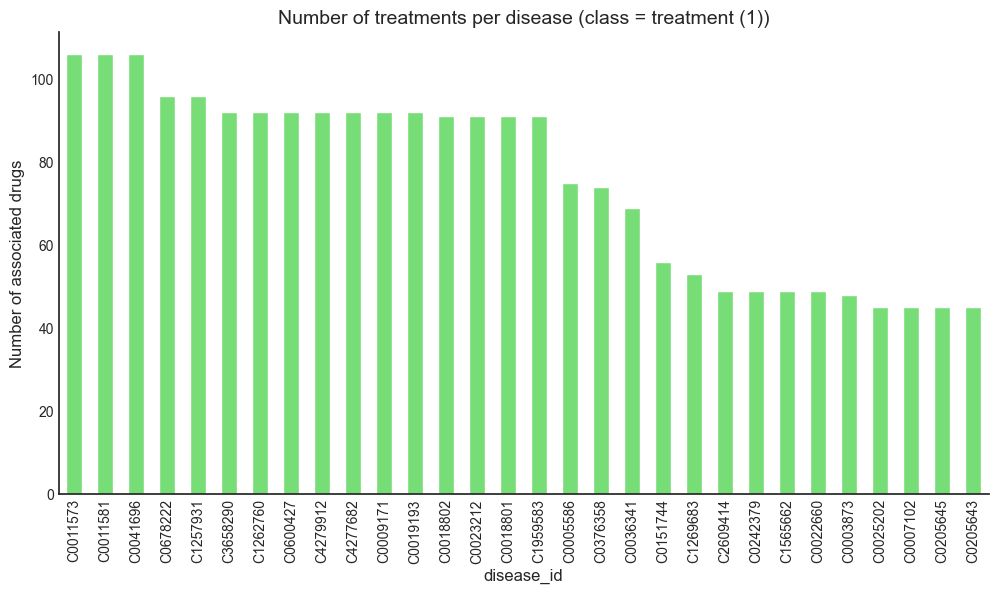

In [29]:
plt.style.use("seaborn-v0_8-white")

disease_drug_count = (
    df_unificado[df_unificado['class'] == 1]
    .groupby('disease_id')['drug_id']
    .nunique()
)

fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")
disease_drug_count.sort_values(ascending=False).head(30).plot(kind='bar', color="#77DD77", ax=ax)

plt.xlabel("disease_id", fontsize=12)
plt.ylabel("Number of associated drugs", fontsize=12)
plt.title("Number of treatments per disease (class = treatment (1))", fontsize=14)
plt.xticks(rotation=90)

plt.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


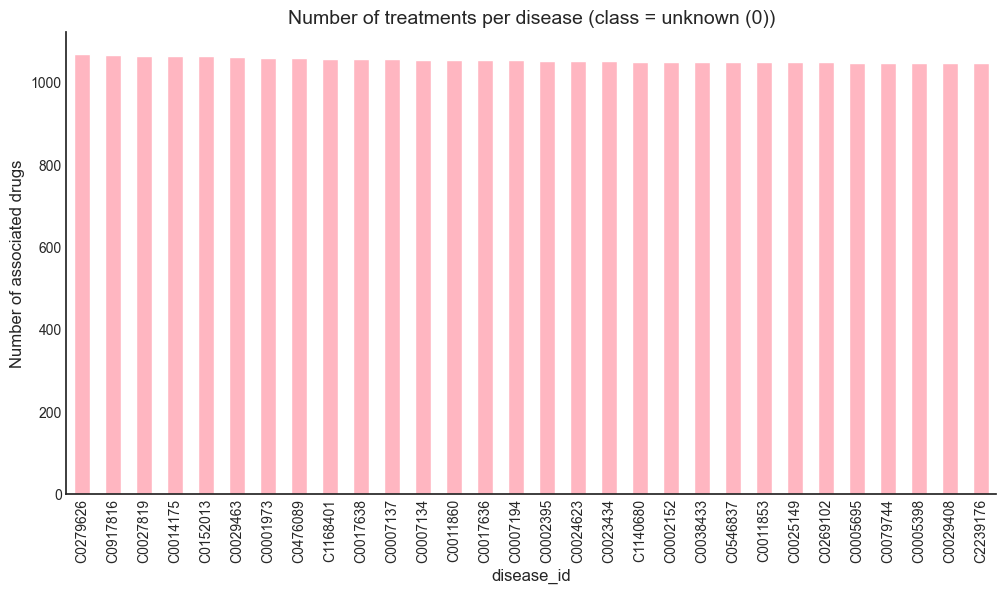

In [30]:
plt.style.use("seaborn-v0_8-white")

disease_drug_count = (
    df_unificado[df_unificado['class'] == 0]
    .groupby('disease_id')['drug_id']
    .nunique()
)

fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")
disease_drug_count.sort_values(ascending=False).head(30).plot(kind='bar', color="#FFB6C1", ax=ax)

plt.xlabel("disease_id", fontsize=12)
plt.ylabel("Number of associated drugs", fontsize=12)
plt.title("Number of treatments per disease (class = unknown (0))", fontsize=14)
plt.xticks(rotation=90)

plt.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

### Gráficas número de enfermedad por tratamiento

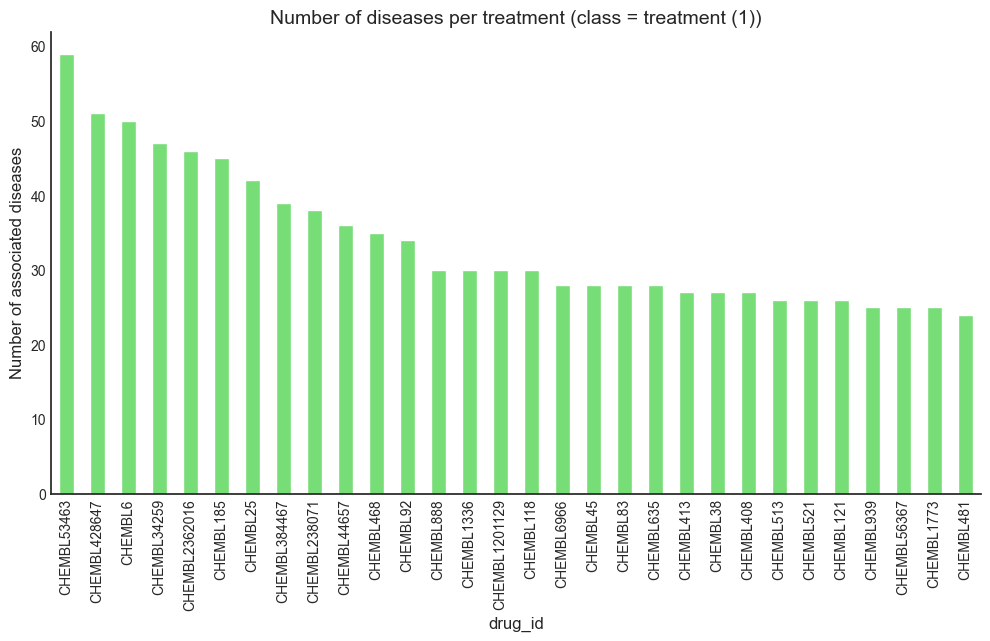

In [31]:
drug_disease_count = (
    df_unificado[df_unificado['class'] == 1]
    .groupby('drug_id')['disease_id']
    .nunique()
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")
drug_disease_count.sort_values(ascending=False).head(30).plot(kind='bar', color="#77DD77", ax=ax)

plt.xlabel("drug_id", fontsize=12)
plt.ylabel("Number of associated diseases", fontsize=12)
plt.title("Number of diseases per treatment (class = treatment (1))", fontsize=14)
plt.xticks(rotation=90)

plt.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


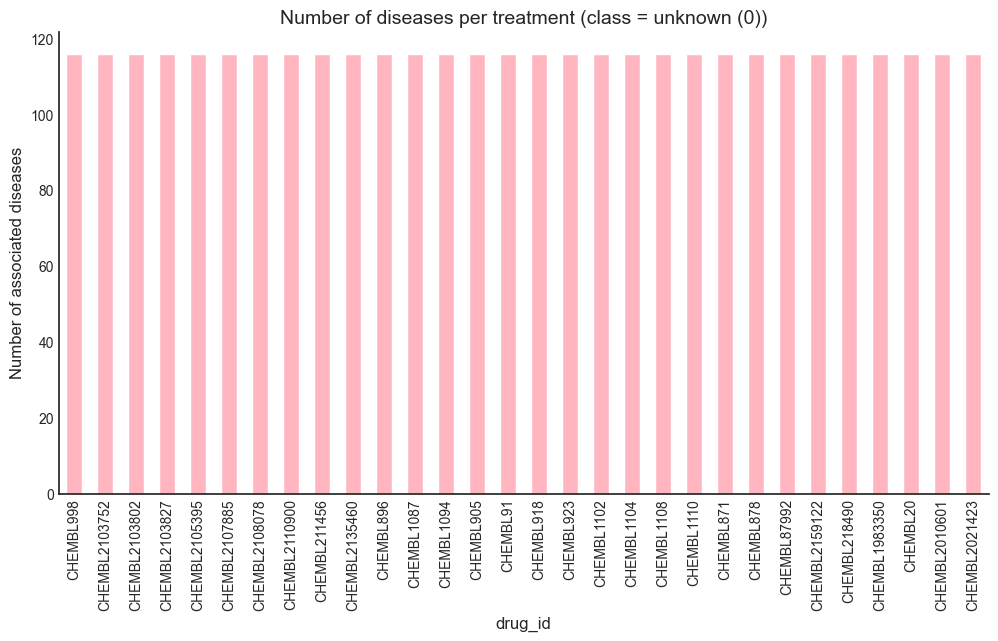

In [32]:
drug_disease_count = (
    df_unificado[df_unificado['class'] == 0]
    .groupby('drug_id')['disease_id']
    .nunique()
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")
drug_disease_count.sort_values(ascending=False).head(30).plot(kind='bar', color="#FFB6C1", ax=ax)

plt.xlabel("drug_id", fontsize=12)
plt.ylabel("Number of associated diseases", fontsize=12)
plt.title("Number of diseases per treatment (class = unknown (0))", fontsize=14)
plt.xticks(rotation=90)

plt.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


## 3.5 Duplicados

Observamos que no hay pares enferemdad - fármacos duplicados

In [33]:
columnas_clave = ['disease_id', 'drug_id']
total_duplicados = df_unificado.duplicated(subset=columnas_clave, keep=False).sum()
print(f"Número total de filas duplicadas en {columnas_clave}: {total_duplicados}")

Número total de filas duplicadas en ['disease_id', 'drug_id']: 0


## 3.6 Nulos

In [34]:
missing_values = df_unificado.isnull().sum()
missing_percentage = (missing_values / len(df_unificado)) * 100

In [35]:
missing_percentage = (missing_values / len(df_unificado)) * 100
print("\nValores nulos por columna:")
print(missing_values)


Valores nulos por columna:
disease_id             0
drug_id                0
path_1                 0
path_2                 0
path_4                 0
path_5                 0
closest_distance    2128
dc_mean             2128
dc_std              2128
proximity           3557
behor                  0
behorC                 0
dmsr                   0
dmsrC                  0
class                  0
dtype: int64


In [36]:
print("\nPorcentaje de valores nulos:")
print(missing_percentage)


Porcentaje de valores nulos:
disease_id          0.000000
drug_id             0.000000
path_1              0.000000
path_2              0.000000
path_4              0.000000
path_5              0.000000
closest_distance    1.721154
dc_mean             1.721154
dc_std              1.721154
proximity           2.876947
behor               0.000000
behorC              0.000000
dmsr                0.000000
dmsrC               0.000000
class               0.000000
dtype: float64


### Nulos por class

In [37]:
df_class0 = df_unificado[df_unificado["class"] == 0]
df_class1 = df_unificado[df_unificado["class"] == 1]

def null_percentage(df_class):
    return (df_class.isnull().sum() / len(df_class)) * 100

nulls_class0 = null_percentage(df_class0)
nulls_class1 = null_percentage(df_class1)

In [38]:
print("\nPorcentaje de nulos en CLASS = 0 (unknown):")
print(nulls_class0)


Porcentaje de nulos en CLASS = 0 (unknown):
disease_id          0.000000
drug_id             0.000000
path_1              0.000000
path_2              0.000000
path_4              0.000000
path_5              0.000000
closest_distance    1.721114
dc_mean             1.721114
dc_std              1.721114
proximity           2.879153
behor               0.000000
behorC              0.000000
dmsr                0.000000
dmsrC               0.000000
class               0.000000
dtype: float64


In [39]:
print("\nPorcentaje de nulos en CLASS = 1 (treatment):")
print(nulls_class1)


Porcentaje de nulos en CLASS = 1 (treatment):
disease_id          0.000000
drug_id             0.000000
path_1              0.000000
path_2              0.000000
path_4              0.000000
path_5              0.000000
closest_distance    1.722210
dc_mean             1.722210
dc_std              1.722210
proximity           2.818161
behor               0.000000
behorC              0.000000
dmsr                0.000000
dmsrC               0.000000
class               0.000000
dtype: float64


Observamos que las métricas de network proximity (closest_distance, dc_mean, dc_std y proximity) presentan valores nulos. No obstante, no es un porcentaje de nulos muy elevado (entre 1% y 3%). Además, es un porcentaje equilibrado en ambas clases. **Optaremos por eliminar las intacias con valores nulos en estas columnas en la fase de  preprocesado.**

## 3.7 OUTLIERS - BOXPLOTS

Realizamos boxplots, uno para cada clase (0 vs 1), de todas las columnas presentes en la tabla unificada.

In [23]:
def plot_boxplot(df, column, class_col='class'):
    data = df[[column, class_col]].dropna(subset=[column])
    if data.empty:
        print(f"No hay datos para la columna '{column}'.")
        return

    plt.style.use("seaborn-v0_8-white")
    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")

    sns.boxplot(
        x=class_col,
        y=column,
        hue=class_col,
        data=data,
        palette={0: "#FFB6C1", 1: "#77DD77"},
        dodge=False,
        ax=ax
    )
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.xlabel('Class', fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.title(f"Boxplot de {column} por Clase", fontsize=14)
    plt.xticks([0, 1], ["Unknown", "Treatment"])
    sns.despine(top=True, right=True)

    plt.tight_layout()
    plt.show()

### VARIABLES GNN

In [24]:
columns_to_plot_gnn = [
    'dmsr', 'dmsrC', 'behor', 'behorC'
]

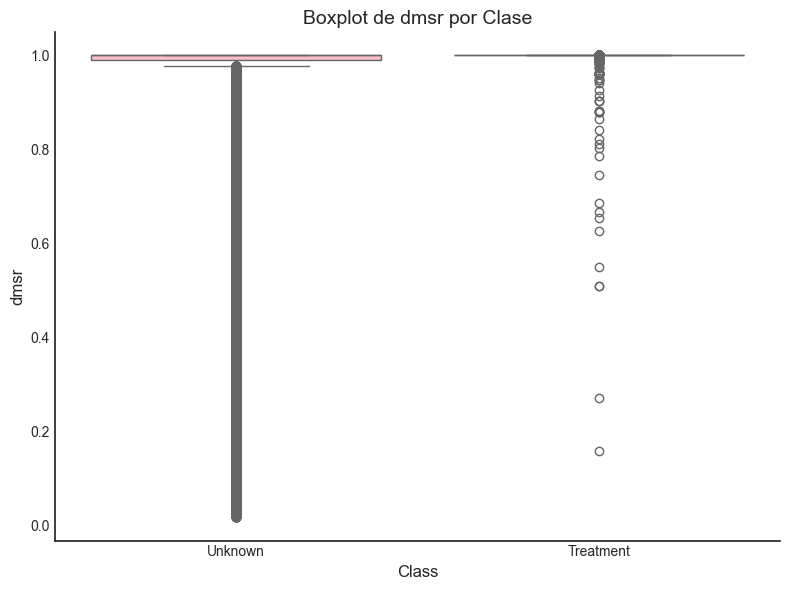

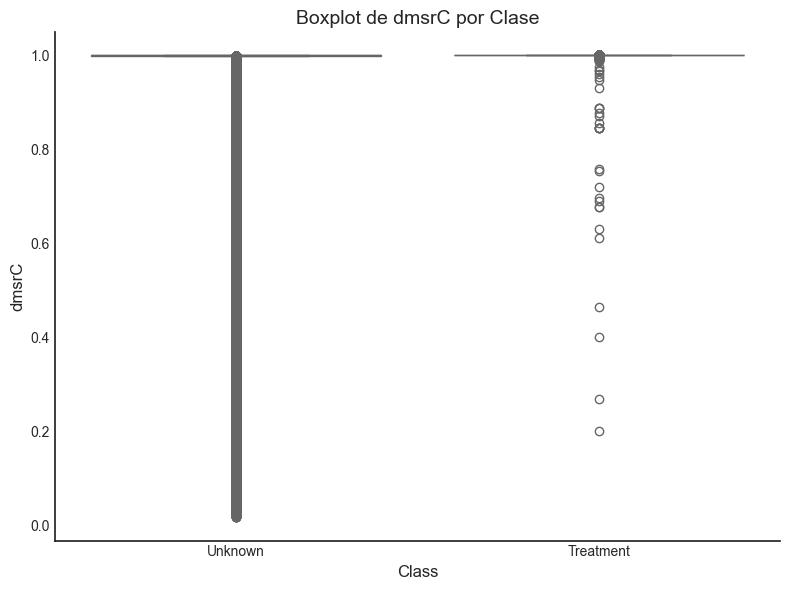

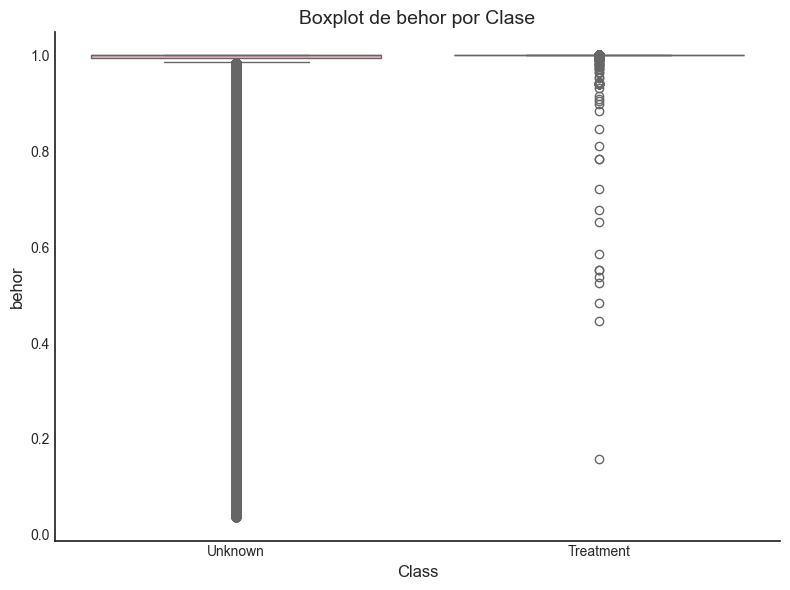

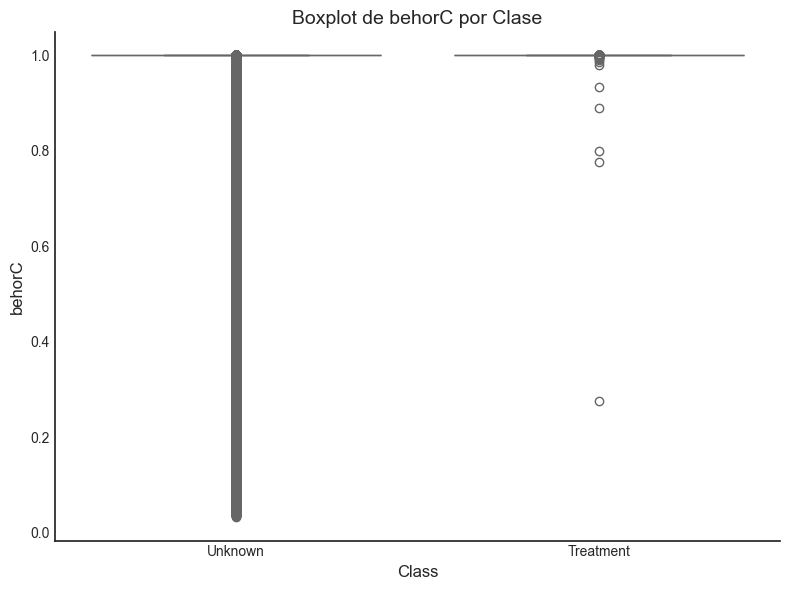

In [25]:
for col in columns_to_plot_gnn:
    plot_boxplot(df_unificado, col)

Observamos una tendencia de concentración en los valores elevados, próximos a 1, en ambas clases (Unknown y Treatment). No obstane, los valores en la clase 0 presentan una mayor dispersión, abarcando hasta valores próximos a 0. En cambio, en la clase 1, los valores tienden a concentrarse en la zona alta (cercana a 1), aunque también se identifican algunos valores atípicos más bajos.

Esto puede deberse, a la diferencia en el número de pares enfermedad-fármaco por clase. Esta mayor dispersión en la clase 0 podría mostrar la heterogeneidad de los pares no validados, lo cual puede ser importante para los modelos de clasificación, al contrastar frente a la clase 1.

### VARIABLES INFORMATION PATH

In [26]:
columns_to_plot_path = [
    'path_1', 'path_2', 'path_4', 'path_5'
]

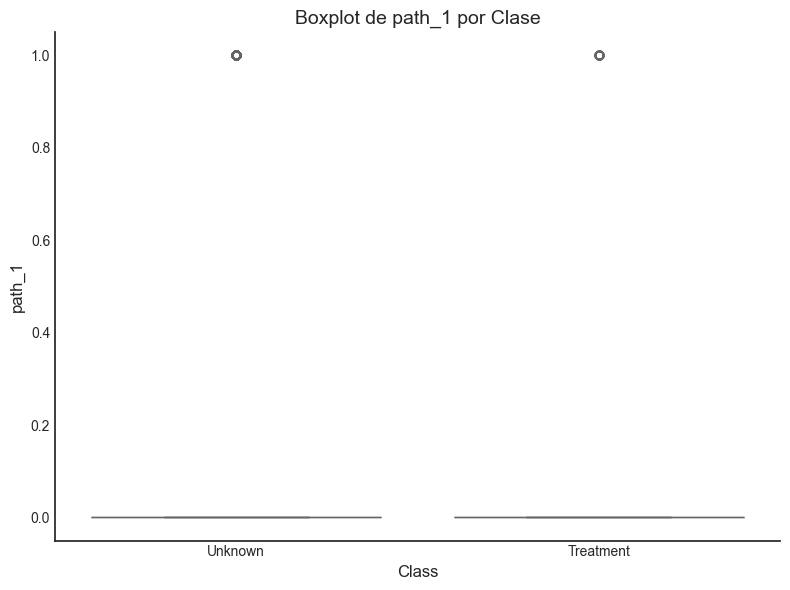

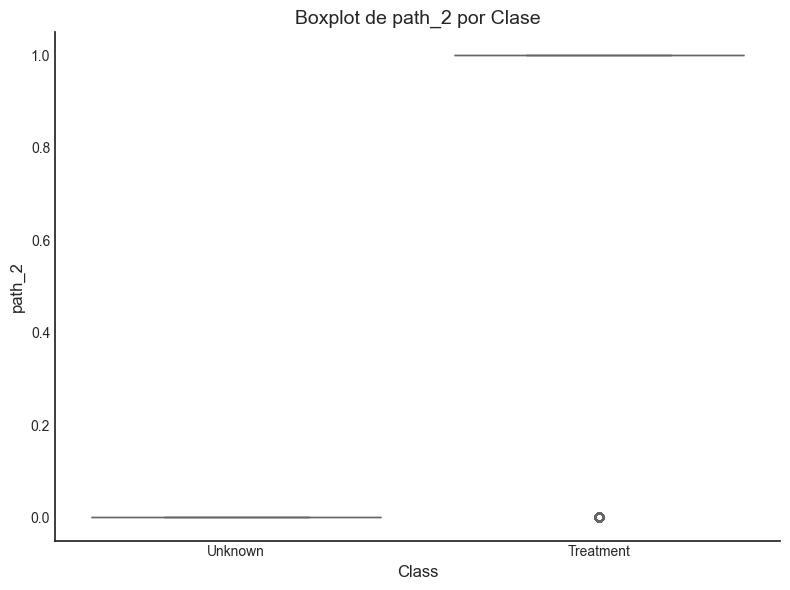

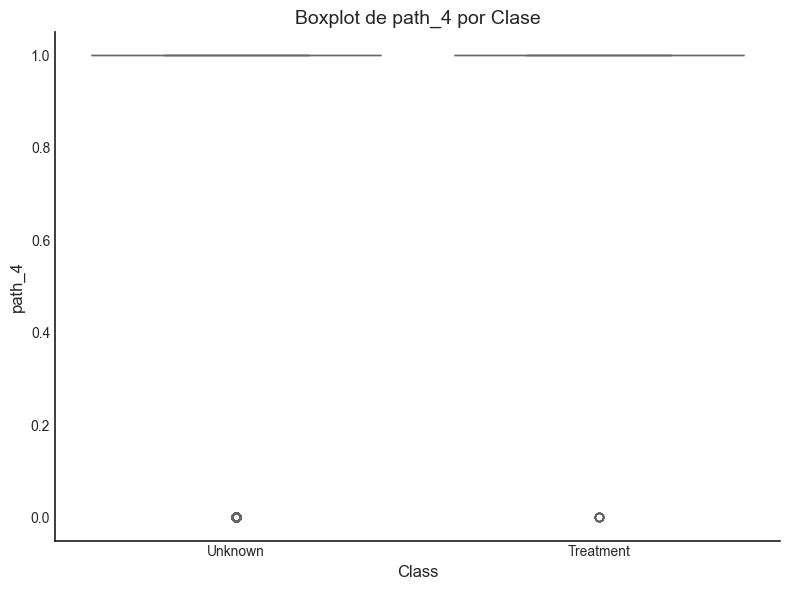

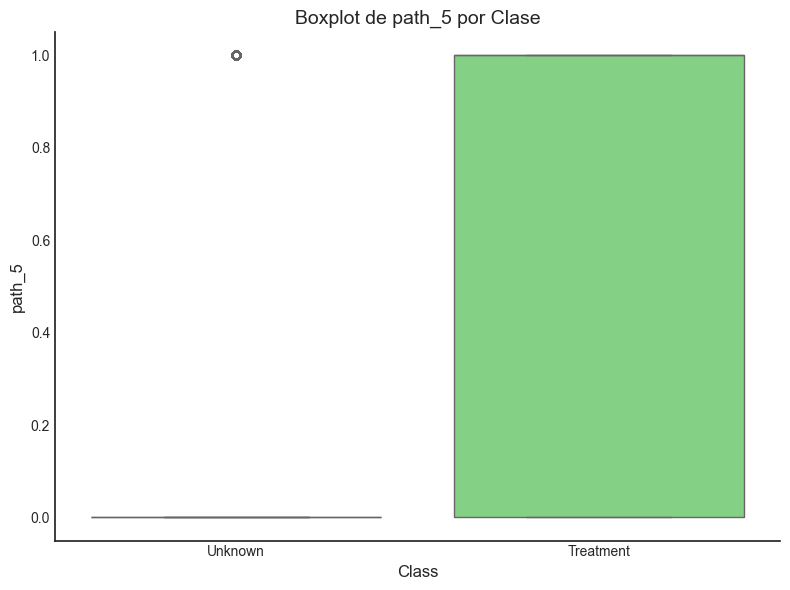

In [27]:
for col in columns_to_plot_path:
    plot_boxplot(df_unificado, col)

Observamos que los boxplots de todos los paths muestran comportamientos distintos entre sí, reflejando la heterogeneidad en la distribución de estos caminos.
Destaca el comportamiento de path_2, ya que presenta un patrón binario muy marcado: en la clase Unknown (0), todos los valores son 0, mientras que en la clase Treatment (1), la mayoría toma el valor 1.
Esta fuerte relación entre path_2 y class refleja una alta correlación entre ambas variables, lo que podría influir en la capacidad predictiva de un modelo de clasificación.

### VARIABLES NETWORK PROXIMITY

In [28]:
columns_to_plot_network = [
    'closest_distance', 'dc_mean', 'dc_std', 'proximity'
]

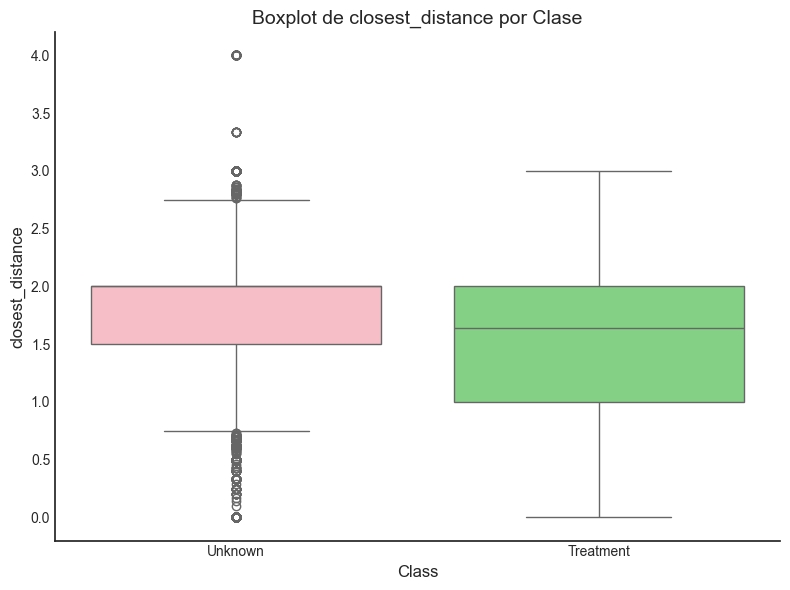

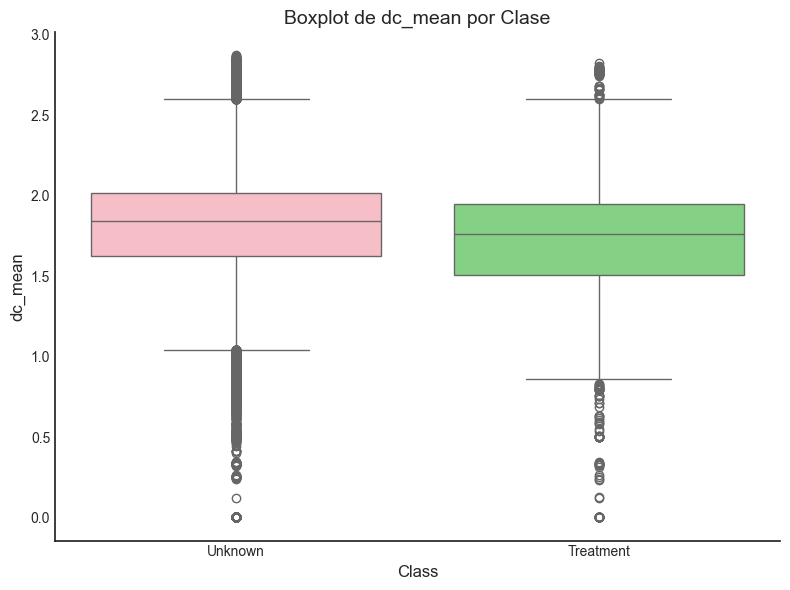

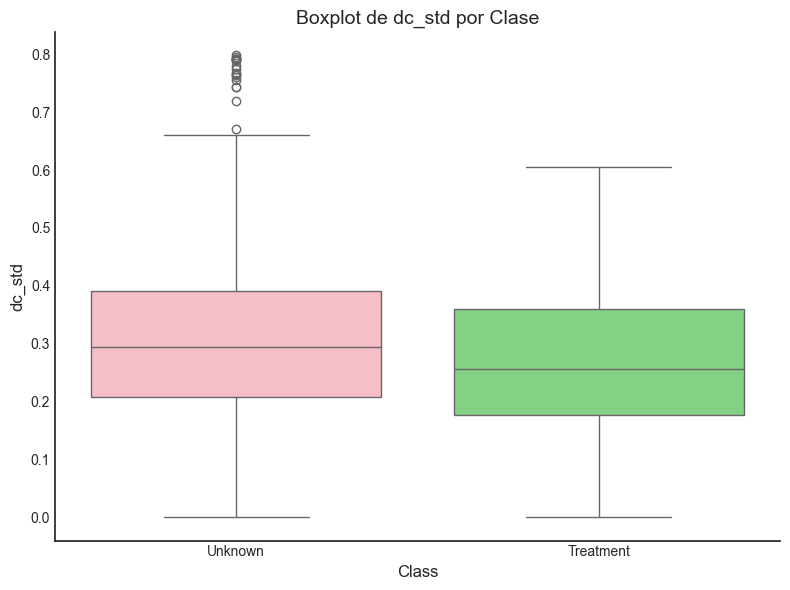

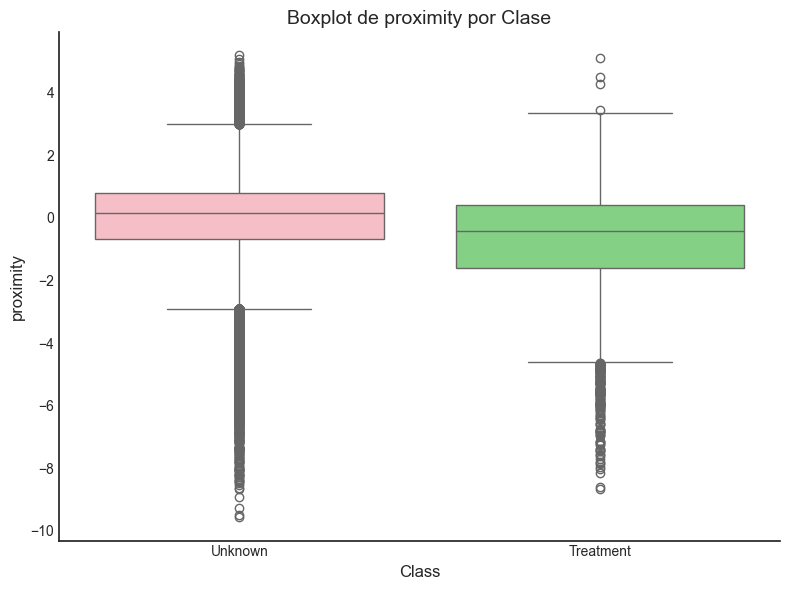

In [29]:
for col in columns_to_plot_network:
    plot_boxplot(df_unificado, col)

En general, las métricas de network proximity (closest_distance, dc_mean, dc_std, proximity) muestran distribuciones similares entre clases, aunque la clase 0 tiende a presentar mayor dispersión y más valores extremos, especialmente en proximity. Esto sugiere una mayor heterogeneidad en los pares no validados.


Observamos que todos los boxplots presentan valores atípicos en ambas clases, no obstante, no tienen por qué ser datos erróneos, ya que se encuentran en un rango razonable que podrían tomar dichas variables.

Esto ocurre debido a que la mayoría de datos se agrupan en un rango muy pequeño, por lo que cualquier valor fuera de este rango se considera atípico.

## 3.8 DISTRIBUCIONES - HISTOGRAMAS

Realizamos histogramas para cada una de las columnas de la tabla integrada. Además, fue necesario hacerlo en escala lográtimica para poder visualizar correctamente los datos.

In [3]:
def plot_histogram(df, column, bins=100):
    data = df[column].dropna()
    if data.empty:
        print(f"No hay datos para la columna '{column}'.")
        return

    range_bins = (data.min(), data.max())
    hist_values, bin_edges = np.histogram(data, bins=bins, range=range_bins)

    plt.style.use("seaborn-v0_8-white")
    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")

    ax.bar(bin_edges[:-1], hist_values, width=np.diff(bin_edges), alpha=0.7, color="#7678ED")
    plt.yscale('log')
    plt.title(f"Distribution of '{column}' (log scale)", fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel("Frequency (log)", fontsize=12)
    plt.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

### VARIABLES GNN

In [9]:
columns_to_plot_gnn = [
    'dmsr', 'dmsrC', 'behor', 'behorC'
]

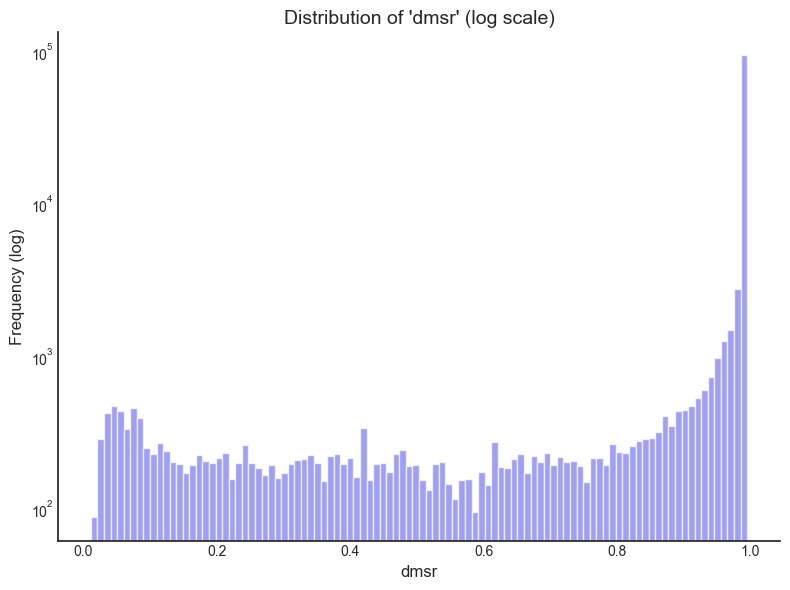

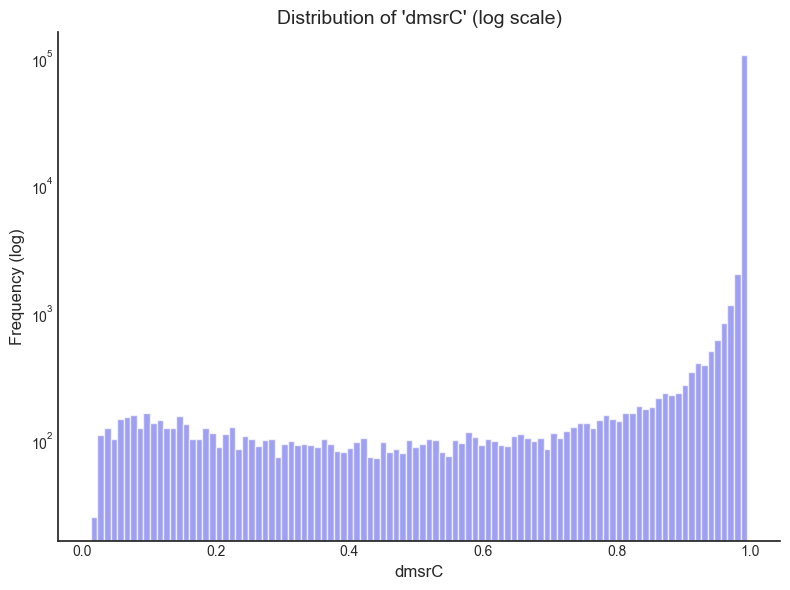

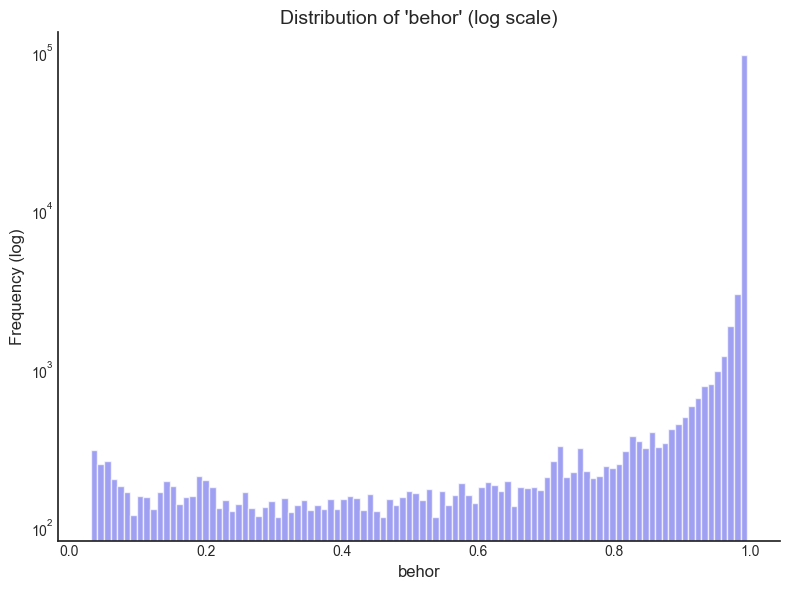

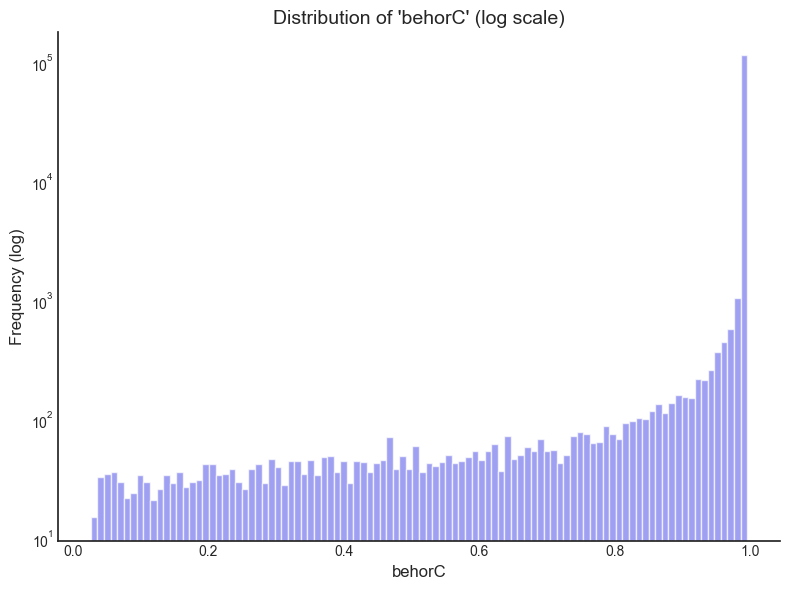

In [10]:
for col in columns_to_plot_gnn:
    plot_histogram(df_unificado, col)

Como se observó anteriormente, las métricas de dr_gnns tienden a concentrarse en valores altos, cercanos a 1. No obstante, sus distribuciones abarcan prácticamente todo el rango entre 0 y 1, lo que indica una heterogeneidad en los valores.

### VARIABLES INFORMATION PATH

In [11]:
columns_to_plot_path = [
    'path_1', 'path_2', 'path_4', 'path_5'
]

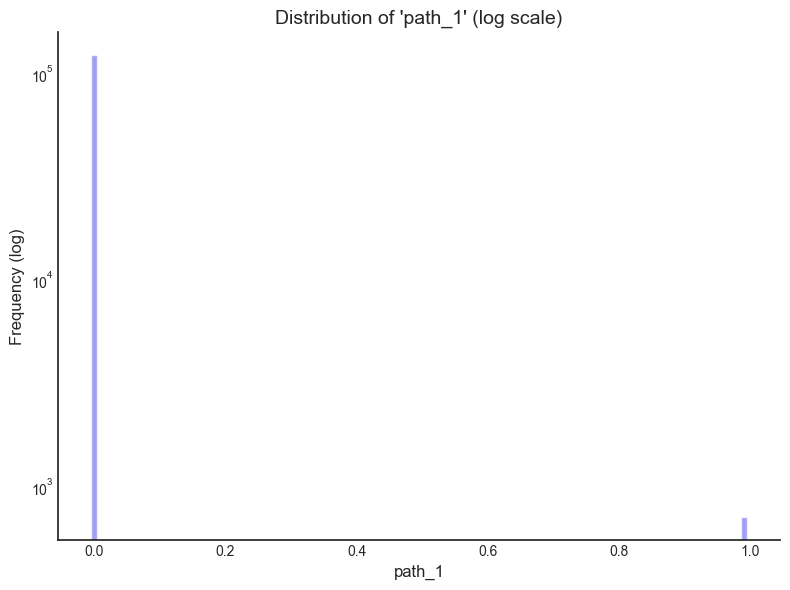

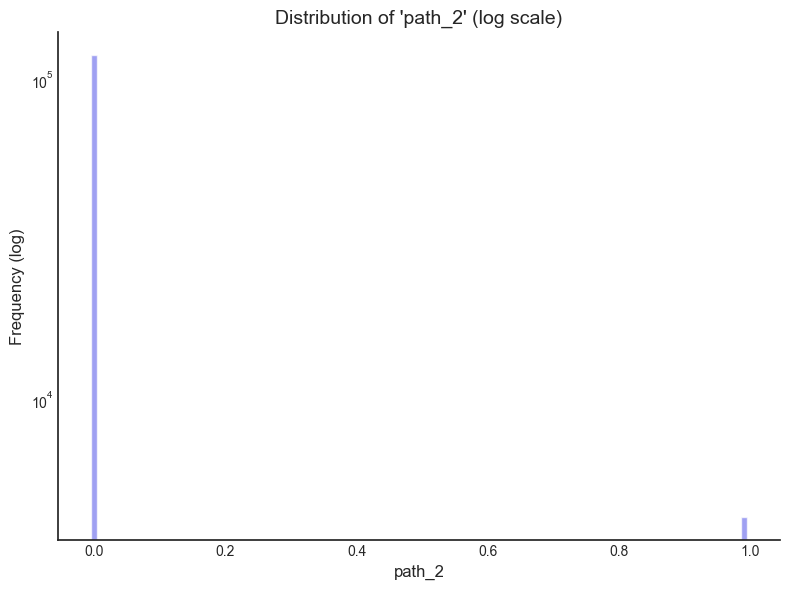

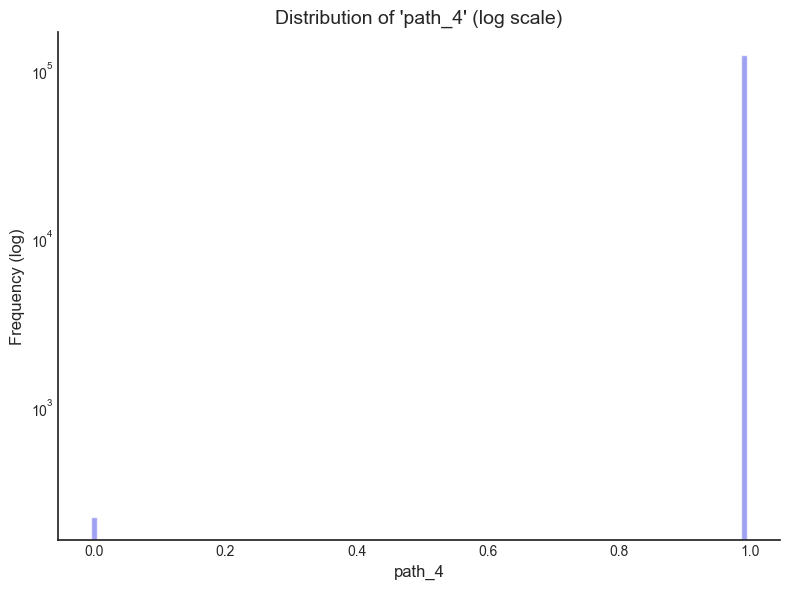

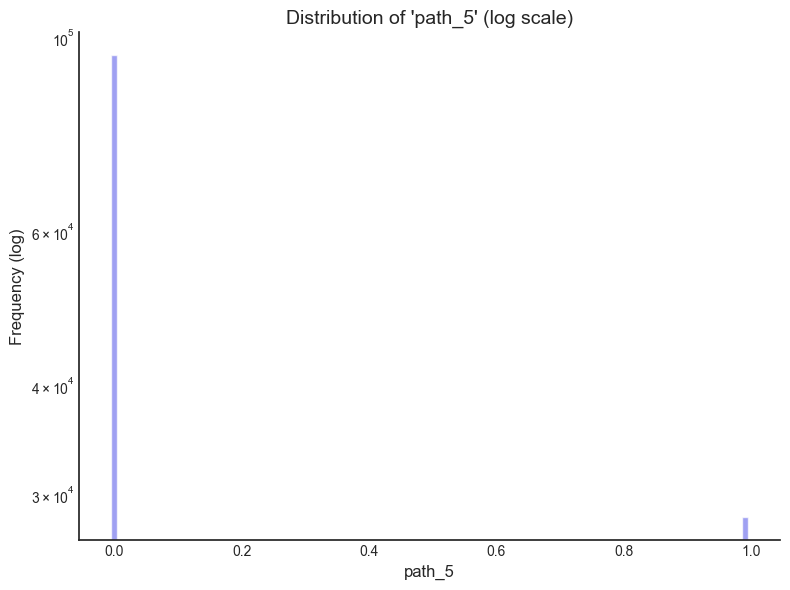

In [12]:
for col in columns_to_plot_path:
    plot_histogram(df_unificado, col)

Al observar los histogramas, se aprecia que en path_1, path_2 y path_5 predominan los valores 0, mientras que en path_4 la mayoría de las instancias toman el valor 1. Sin embargo, dado que la clase positiva (class = 1) representa un pequeño porcentaje del total (3% de los datos), esta alta activación de path_4 también ocurre mayoritariamente en pares que no están clínicamente validados.
Por tanto, aunque path_4 refleja una vía frecuentemente explorada por el modelo para generar hipótesis, no se puede asumir directamente que su presencia implique una alta probabilidad de reposicionamiento, ya que también se activa en muchos pares con class = 0.

### VARIABLES NETWORK PROXIMITY

In [13]:
columns_to_plot_network = [
    'closest_distance', 'dc_mean', 'dc_std', 'proximity'
]

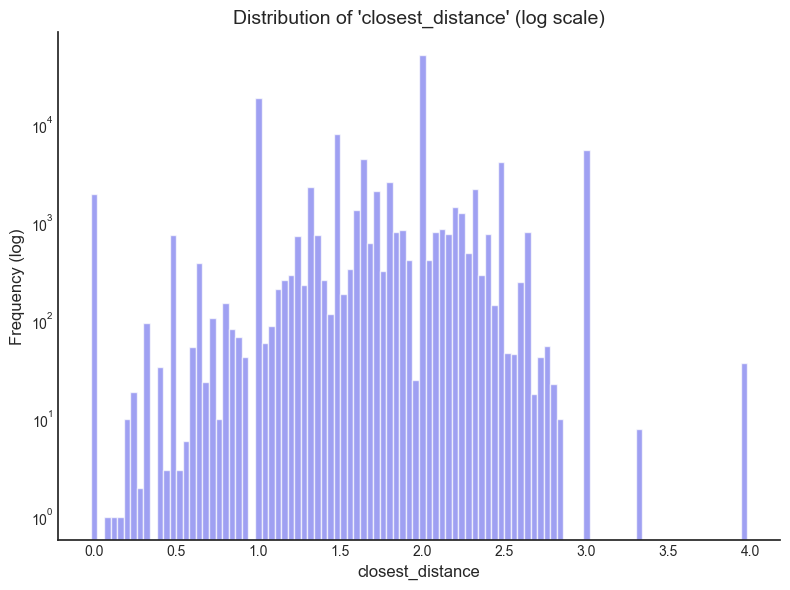

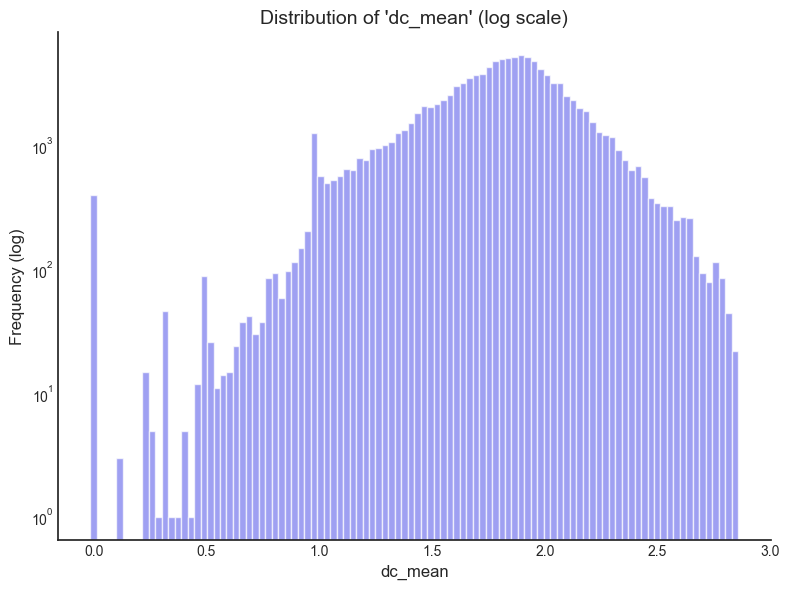

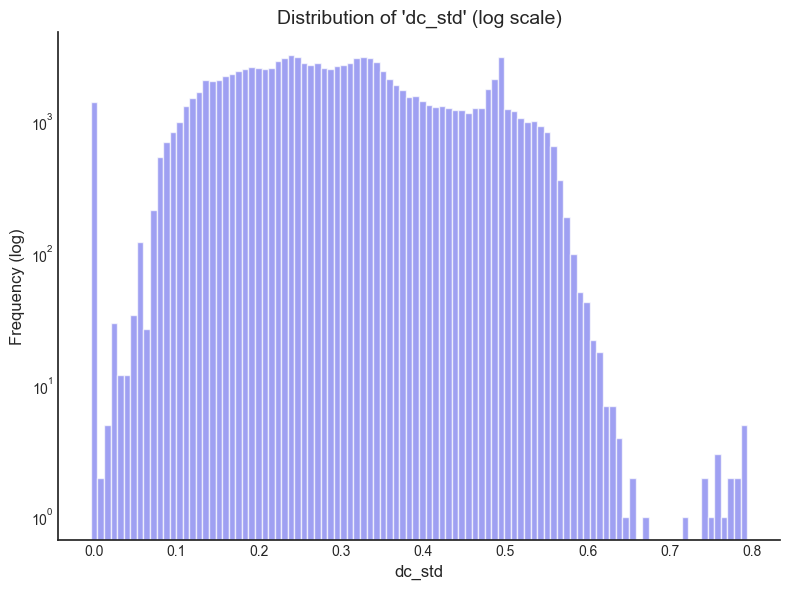

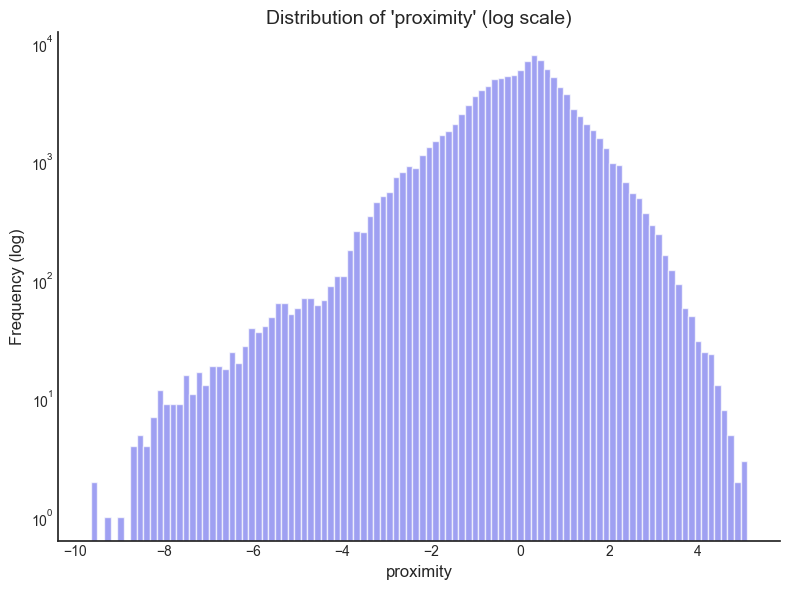

In [14]:
for col in columns_to_plot_network:
    plot_histogram(df_unificado, col)

Las métricas de network proximity presentan distribuciones más amplias que el rango [0, 1]. closest_distance y dc_mean  se concentran en valores intermedios, con mínimos cercanos a 0 y máximos en torno a 3–4, mientras que dc_std alcanza como máximo valores de 0.8. En proximity, se observan pares con valores negativos, llegando incluso hasta -10.

## 3.9 MATRIZ DE CORRELACIÓN

Visualizamos la matriz de correlación entre todas las métricas de la tabla unificada para identificar posibles relaciones entre variables y facilitar la interpretación del comportamiento del metamodelo. Esto permite detectar qué métricas podrían tener mayor o menor influencia en la clasificación.

Para ello, utilizamos la **correlación de Spearman**, ya que es más robusta frente a distribuciones no normales, outliers y relaciones no lineales, condiciones que se cumplen en varias de las métricas analizadas.


In [66]:
columnas_numericas = ['path_1', 'path_2', 'path_4', 'path_5',
       'closest_distance', 'dc_mean', 'dc_std', 'proximity',
       'dmsr', 'dmsrC', 'behor', 'behorC', 'class']

In [67]:
df_numerico = df_unificado[columnas_numericas].copy()
df_numerico = df_numerico.dropna()

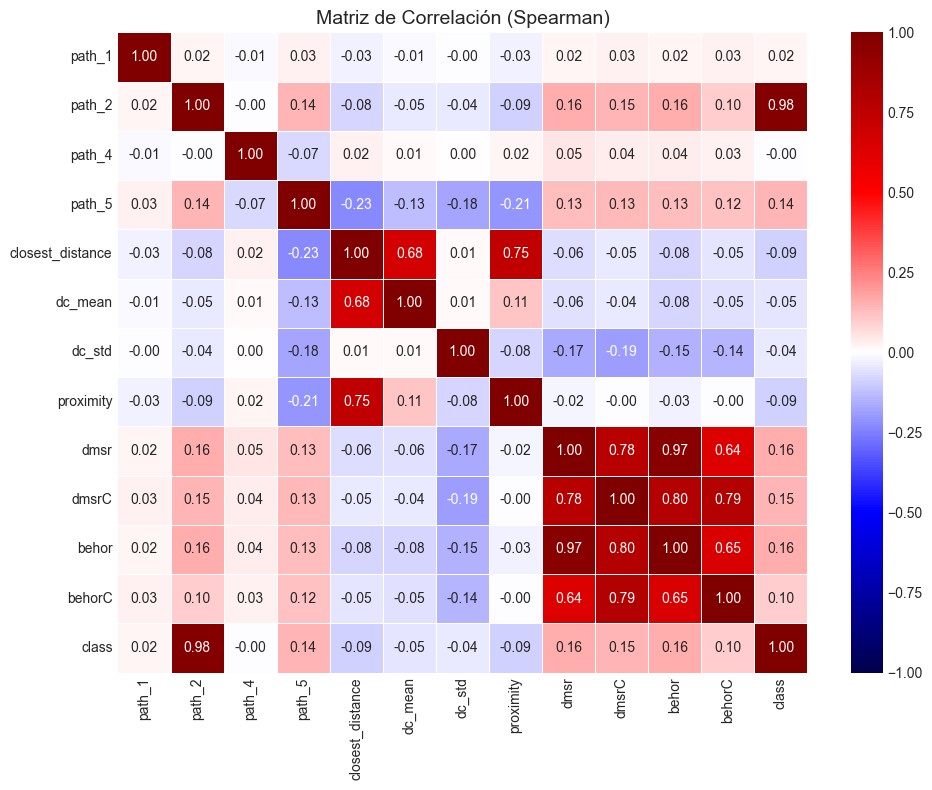

In [68]:
correlation_matrix = df_numerico.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="seismic",
            vmin=-1, vmax=1,
            fmt=".2f",
            linewidths=0.5)

plt.title("Matriz de Correlación (Spearman)", fontsize=14)
plt.tight_layout()
plt.show()

 Se observa que no existe una correlación fuerte entre métricas provenientes de modelos diferentes, lo cual era esperable y refuerza el objetivo de construir un metamodelo integrador

Por otro lado, las métricas del **modelo GNN** (dmsr, dmsrC, behor, behorC) presentan alta correlación entre sí (valores entre 0.78 y 0.97), lo que indica que capturan información similar. Algo parecido ocurre con ciertas métricas del **modelo network proximity**, donde destacan correlaciones moderadas como entre dc_mean y closest_distance (ρ = 0.68) y proximity y closest_distance (ρ = 0.75).

Es  destacable el caso de **path_2**, que muestra una correlación de 0.98 con la variable class. Esta relación tan elevada sugiere una fuga de información, probablemente porque path_2 está considerando caminos a través de enfermedades con síntomas similares, enlazando directamente con los tratamientos ya aprobados. Esto provoca una correlación artificial con la variable class, contaminando el entrenamiento del modelo. Por tanto, path_2 será eliminada del conjunto de características para evitar sesgos y garantizar una evaluación realista del rendimiento del metamodelo.

## 3.10 SCATTER PLOTS

Para completar el análisis anterior, se realizaron los scatter plots de pares con alta correlación, así como de aquellos con baja o nula correlación. Esto permite observar visualmente las relaciones entre las variables y cómo se distribuyen en las diferentes clases (Unknown vs Treatment).

C:\Users\USUARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


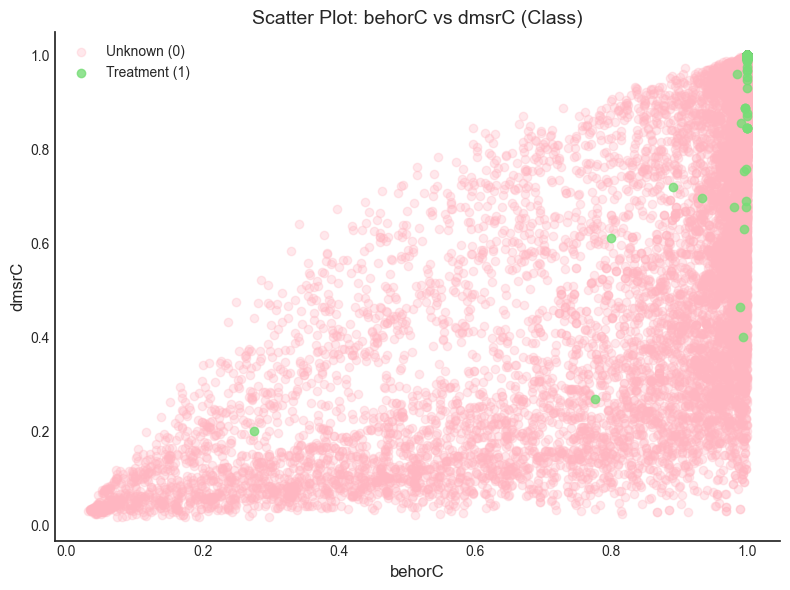

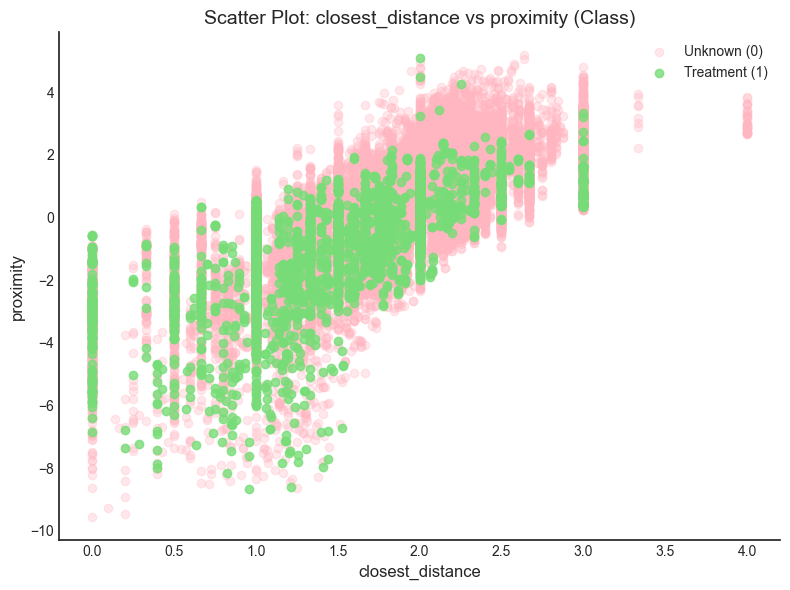

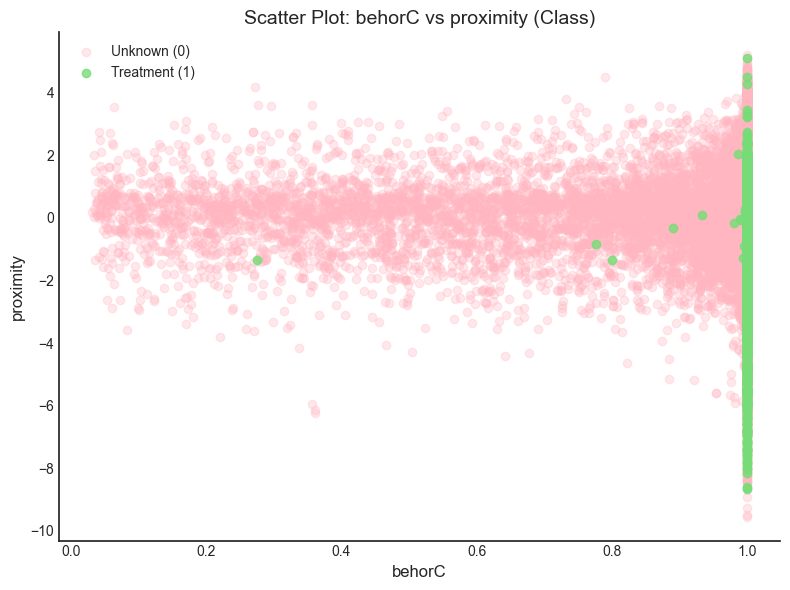

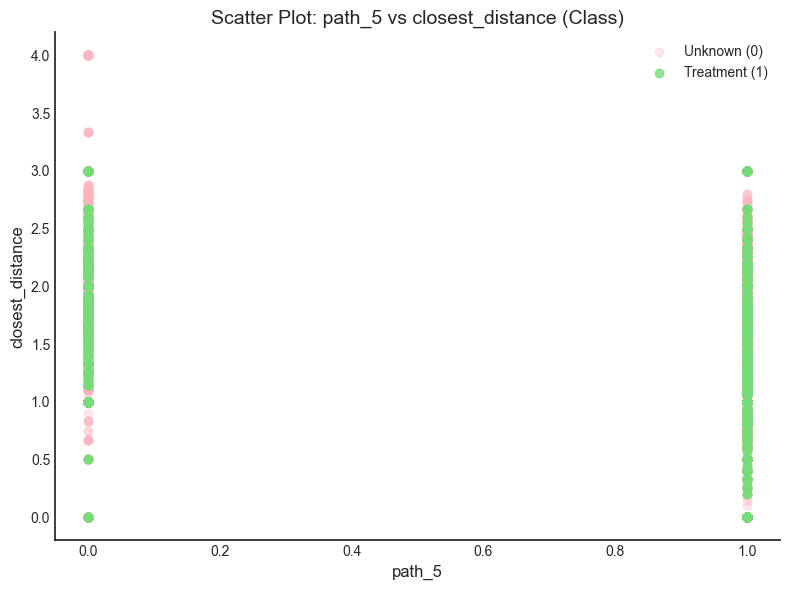

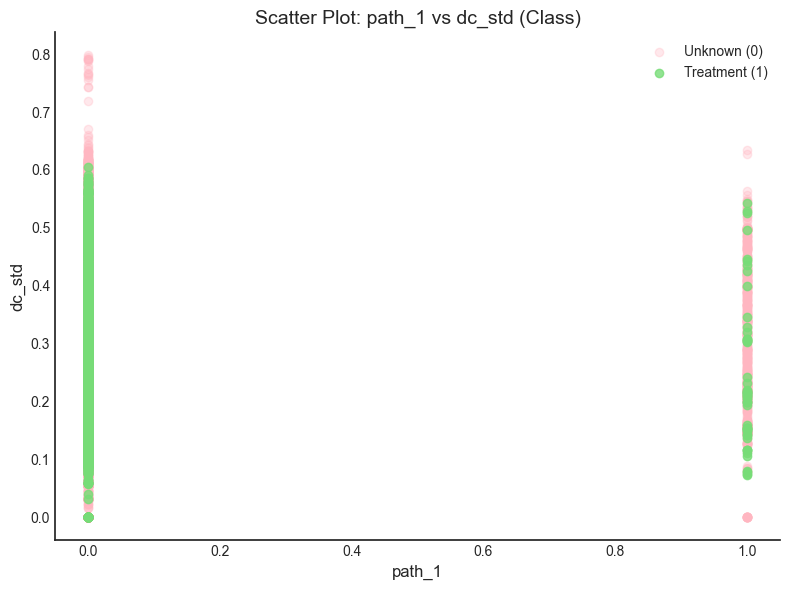

In [70]:
plt.style.use("seaborn-v0_8-white")

pairs_to_plot = [
    ("behorC", "dmsrC"), #alta correlación positiva
    ("closest_distance", "proximity"), #alta correlación positiva
    ("behorC", "proximity"), #nula correlación
    ("path_5", "closest_distance"), #correlación negativa
    ("path_1", "dc_std") #nula correlación
]

df_class_0 = df_unificado[df_unificado['class'] == 0]
df_class_1 = df_unificado[df_unificado['class'] == 1]

for x_var, y_var in pairs_to_plot:
    fig, ax = plt.subplots(figsize=(8, 6), facecolor="white")
    plt.scatter(df_class_0[x_var], df_class_0[y_var],
                color='#FFB6C1', alpha=0.3, label='Unknown (0)')
    plt.scatter(df_class_1[x_var], df_class_1[y_var],
                color='#77DD77', alpha=0.8, label='Treatment (1)')

    plt.xlabel(x_var, fontsize=12)
    plt.ylabel(y_var, fontsize=12)
    plt.title(f"Scatter Plot: {x_var} vs {y_var} (Class)", fontsize=14)

    sns.despine(top=True, right=True)
    plt.grid(False)
    plt.legend()
    plt.tight_layout()
    plt.show()
